# 4. Modeling

In [3]:
#import all libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, recall_score
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import eli5
from eli5.sklearn import PermutationImportance

## 4.1 Preparing data for modeling

Load in original dataset

In [4]:
df = pd.read_json('train.json')
df.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


Apply changes from data cleaning and feature engineering to dataframe.

In [5]:
#drop outliers (from data cleaning)
df = df[(df['bathrooms'] != 0) | (df['bathrooms'] != 10)]
df = df[df['bedrooms'] <= 6]
df = df[df['building_id'].str.len() >= 32]
df = df[df['price'] < 1000000]

In [6]:
#feature engineering photos
df =df.copy()
df['num_photos'] = df['photos'].apply(len)
df['num_features'] = df['features'].apply(len)
df['num_description_words'] = df['description'].apply(lambda x: len(x.split(' ')))

In [7]:
#feature engineering features
df['features_new'] = df["features"].apply(lambda y: " ".join(["_".join(x.split(" ")).lower() for x in y]))

def add_feature(row):
    if re.search(r'hardwood',row['features_new'],re.IGNORECASE)!=None:
        row['hardwood']=1
    else:
        row['hardwood']=0
        
    if re.search(r'doorman',row['features_new'],re.IGNORECASE)!=None:
        row['doorman']=1
    else:
        row['doorman']=0
    
    if re.search(r'fee',row['features_new'],re.IGNORECASE)!=None:
        row['fee']=1
    else:
        row['fee']=0
    
    if re.search(r'cats',row['features_new'],re.IGNORECASE)!=None:
        row['cats']=1
    else:
        row['cats']=0

    if re.search(r'laundry',row['features_new'],re.IGNORECASE)!=None:
        row['laundry']=1
    else:
        row['laundry']=0

    if re.search(r'war\Z|war\s|war_',row['features_new'],re.IGNORECASE)!=None: #makes sure that "war" is only connected to "pre" and "post" and not just included in a word like "wardrobe"
        row['war']=1
    else:
        row['war']=0

    if re.search(r'fitness',row['features_new'],re.IGNORECASE)!=None:
        row['fitness']=1
    else:
        row['fitness']=0
        
    if re.search(r'elevator',row['features_new'],re.IGNORECASE)!=None:
        row['elevator']=1
    else:
        row['elevator']=0
        
    if re.search(r'dishwasher',row['features_new'],re.IGNORECASE)!=None:
        row['dishwasher']=1
    else:
        row['dishwasher']=0
        
    if re.search(r'dogs',row['features_new'],re.IGNORECASE)!=None:
        row['dogs']=1
    else:
        row['dogs']=0
        
    return row

df=df.apply(add_feature,axis=1)

In [9]:
#feature engineering longitude and lattitude
addresssplit = pd.read_csv('addresshousing.csv')
addresssplit=pd.concat([addresssplit, addresssplit['address'].str.split(', ', expand=True)], axis=1)
df1=addresssplit.rename({0:'Streetnumber',1:'Streetname',2:'neighbourhood',3:'Community'}, axis='columns')
df1=df1[['building_id','interest_level', 'price','listing_id','Streetnumber','Streetname','neighbourhood','Community']].sort_values(by=['listing_id'])
df1['Stname'] = df1['Streetname'].where(df1['Streetname'].str.match(r'\D', na=False))
df1['Stname']=df1['Stname'].mask(pd.isnull, df1['Streetnumber'])
df1['Stnumber'] = df1['Streetnumber'].where(df1['Streetnumber'].str.match(r'^\d+$', na=True))
df1['Stnumber']=df1['Stnumber'].mask(pd.isnull, df1['Streetname'])
df1=df1.drop(columns=['Streetnumber', 'Streetname'])
df1=df1.dropna()

new_columns = ['The Bronx', 'Lenox Hill', 'Queens', 'Stuy Town', 'Bay Ridge', 'Steinway', 'Sunset Park', 'Upper West Side', 'Gramercy', 'Park Slope']
df1 = df1.reindex(columns = [*df1.columns.tolist(), *new_columns])

for index, row in df1.iterrows():
    for word in new_columns:
        if word == row['neighbourhood']:
            df1.at[index, word] = '1'
        else:
            df1.at[index, word] = '0'
            
df_merge = df1[['listing_id', 'The Bronx', 'Lenox Hill', 'Queens', 'Stuy Town', 'Bay Ridge', 'Steinway', 'Sunset Park', 'Upper West Side', 'Gramercy', 'Park Slope']]
df = df.merge(df_merge, how='left', on='listing_id')

In [10]:
#feature engineering description
new_columns = ['new', 'renovated', 'high' 'large', 'great', 'restaurants', 'park', 'spacious', 'beautiful', 'access', 'center']
df = df.reindex(columns = [*df.columns.tolist(), *new_columns])

for index, row in df.iterrows():
    for word in new_columns:
        if word in row['description'].lower():
            df.at[index, word] = '1'
        else:
            df.at[index, word] = '0'

Column "created" in the dataset can't be used as one of the model features since it is a datetime data type. It will be disagregated into other time components (e.g. year, month, day, etc.) and fed to the model.

In [11]:
#disagregating created into smaller time segments to use as features in the model
df['created'] = pd.to_datetime(df.created) #converting created to datetime object
df['year'] = df['created'].dt.year
df['month'] = df['created'].dt.month
df['day'] = df['created'].dt.day
df['hour'] = df['created'].dt.hour
df['weekday'] = df['created'].dt.day_name()

In [12]:
#checking categorical columns left
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41058 entries, 0 to 41057
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   building_id      41058 non-null  object
 1   description      41058 non-null  object
 2   display_address  41058 non-null  object
 3   features         41058 non-null  object
 4   manager_id       41058 non-null  object
 5   photos           41058 non-null  object
 6   street_address   41058 non-null  object
 7   interest_level   41058 non-null  object
 8   features_new     41058 non-null  object
 9   weekday          41058 non-null  object
dtypes: object(10)
memory usage: 4.7+ MB


In [13]:
#dropping irrelevant columns from the dataset to fit into the model later
df_model = df.drop(['description', 'listing_id', 'display_address', 'features', 'features_new', 'manager_id', 'photos', 'street_address', 'created', 'building_id'], axis=1)

In [14]:
#checking categorical columns
df_model.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41058 entries, 0 to 41057
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   interest_level  41058 non-null  object
 1   weekday         41058 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [15]:
df_model.isnull().sum()[df_model.isnull().sum() > 0] #we have some missing values which should be dropped for model fitting

The Bronx          12
Lenox Hill         12
Queens             12
Stuy Town          12
Bay Ridge          12
Steinway           12
Sunset Park        12
Upper West Side    12
Gramercy           12
Park Slope         12
dtype: int64

In [16]:
df_model.dropna(axis=0, inplace=True)

In [17]:
df_model = pd.get_dummies(columns=['weekday'], data = df_model)

In [18]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41046 entries, 0 to 41057
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bathrooms              41046 non-null  float64
 1   bedrooms               41046 non-null  int64  
 2   latitude               41046 non-null  float64
 3   longitude              41046 non-null  float64
 4   price                  41046 non-null  int64  
 5   interest_level         41046 non-null  object 
 6   num_photos             41046 non-null  int64  
 7   num_features           41046 non-null  int64  
 8   num_description_words  41046 non-null  int64  
 9   hardwood               41046 non-null  int64  
 10  doorman                41046 non-null  int64  
 11  fee                    41046 non-null  int64  
 12  cats                   41046 non-null  int64  
 13  laundry                41046 non-null  int64  
 14  war                    41046 non-null  int64  
 15  fi

The data will be split into the train, validation and test sets. First the model will be trained on the train set, after which it will be pruned on the validation set and finally, it will be tested on the test set.

**Splitting into train, validation and test data**

In [19]:
np.random.seed(123)
df_model = df_model.sample(frac=1) # shuffle data
df_dev, df_test = train_test_split(df_model, test_size=0.15)
df_train, df_valid = train_test_split(df_dev, test_size=0.15)

In [20]:
x_train = df_train.drop('interest_level', axis=1)
y_train = df_train['interest_level']

x_valid = df_valid.drop('interest_level', axis=1)
y_valid = df_valid['interest_level']

x_test = df_test.drop('interest_level', axis=1)
y_test = df_test['interest_level']

## 4.2 Random Forest
We will build several models that could potentially predict the outcome (interest level). Decision trees and random forests will be used as fitting models. We chose these models as they are one of the most widely used classification models which usually show good performance.
The model will be trained on the train set and then the performance will be checked on the validation set. Afterwards, model pruning will be conducted with cross-validation on the validation set to ensure high model performance and low risk of overfitting. The final model will be tested on the test set, hopefully with significant results :)

In [21]:
rf1 = RandomForestClassifier(random_state=42).fit(x_train,y_train)
y_pred = rf1.predict(x_valid)
y_pred_prova = rf1.predict_proba(x_valid)

In [22]:
pprint('Parameters currently in use:\n')
pprint(rf1.get_params())

'Parameters currently in use:\n'
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In order to check the model performance, several indicators were chosen:
- log loss 
- accuracy score
- recall score
- ROC AUC score

Log loss was chosen as the basic loss function of classification algorithms. The choice of other metrics is explained by the fact that different metrics should be compared to get a holistic view of model performance.

In [23]:
#checking model performance
log_loss1 = log_loss(y_valid, y_pred_prova)
print("Log loss score: ", log_loss1)
acc1 = accuracy_score(y_valid, y_pred)
print("Accuracy score: ",acc1)
rec1 = recall_score(y_valid, y_pred, average='weighted')
print("Recall score: ", rec1)
roc_auc1 = roc_auc_score(y_valid, y_pred_prova, multi_class='ovo')
print("ROC AUC score: ", roc_auc1)

Log loss score:  0.7020605318699571
Accuracy score:  0.6916316392816202
Recall score:  0.6916316392816202
ROC AUC score:  0.742914165860356


To understand the model performance better as well to be able to communicate findings to others, it is important to indentify which features are doing best in terms of predicting the outcome. To get this information, MDI (mean decrease impurity) and MDA (mean decrease in accuracy) (permutation) features importances are calculated.

In [24]:
#top 20 mdi importances
feature_imp_mdi = pd.Series(rf1.feature_importances_,index=x_train.columns).sort_values(ascending=False)
feature_mdi_top20 = feature_imp_mdi[:20]

In [25]:
#top 20 permutation (mda) importances
MDA_importances = permutation_importance(rf1, x_train, y_train, random_state=42, n_jobs=2)
MDA_importances = MDA_importances.importances_mean
feature_imp_mda =  pd.Series(MDA_importances,index=x_train.columns).sort_values(ascending=False)
feature_mda_top20 = feature_imp_mda[:20]

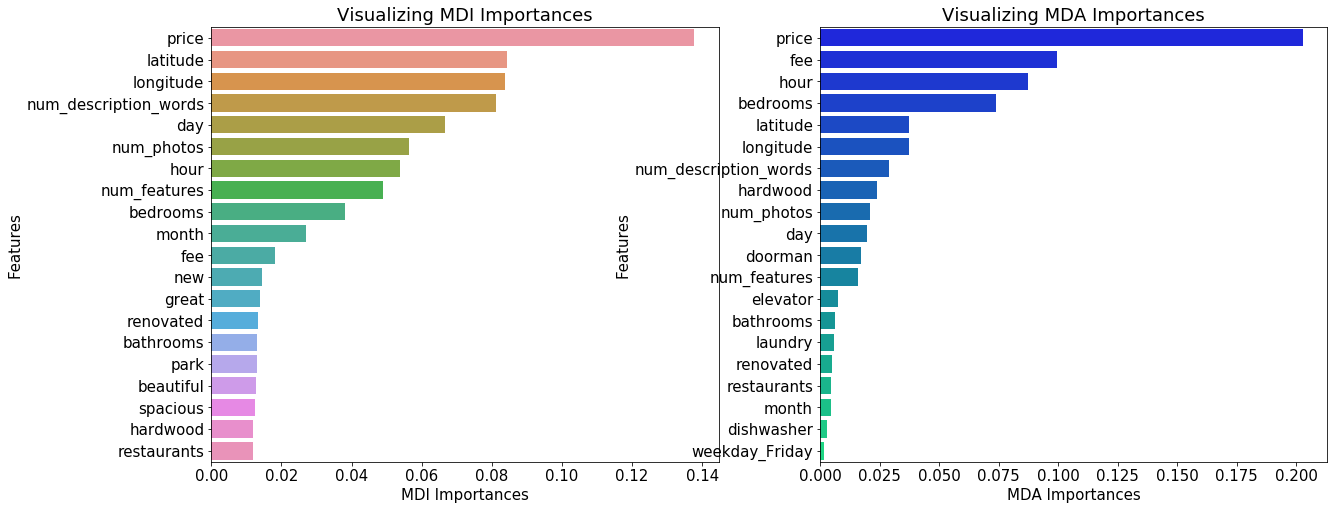

In [26]:
#plotting importances
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x=feature_mdi_top20, y=feature_mdi_top20.index)
plt.xlabel('MDI Importances', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title("Visualizing MDI Importances", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1,2,2)
sns.barplot(x=feature_mda_top20, y=feature_mda_top20.index, palette='winter')
plt.xlabel('MDA Importances', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title("Visualizing MDA Importances", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

As it is stated on scikits website, the impurity based feature importance (MDI) also named random forest feature importance can inflate the importance of numerical features. (Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

In our model, this can be verfied by looking at latitude and longitude. On the left plot for MDI, these two features are on the 2nd and 3rd rank, whereas on the right plot, they are only at the 5th and 6th spot. Therefore, we will prefer permutation importance (MDA) from this point on in order to estimate the feature importance of our models.

**Random Forest Pruning**

As we only have a vague idea of the best hyperparameters and thus the best approach to narrow our search is to evaluate a wide range of values for each hyperparameter. Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.
How do we know from which parameters to choose? One approach could be checking the documentation on the random forest in Scikit-Learn which reveals that important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features). However, we will also pick other hyperparameters and check the performance of all possible combinations. We will do the tuning in the validation set and then test it on the test set.

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500]}


In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf2 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, scoring='roc_auc_ovo', random_state=42, n_jobs = -1)
# Fit the random search model on the validation set
rf_random.fit(x_valid, y_valid)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 144, 188, 233,
                                                         277, 322, 366, 411,
                                                         455, 500]},
                   random_state=42, scoring='roc_auc_ovo', verbose=2)

In [29]:
print("The best hyperparameters for the model are: ", rf_random.best_params_)

The best hyperparameters for the model are:  {'n_estimators': 188, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}


Now we will tun the model with the suggested best hyperparameter set. Also, we will check and play with some other numbers to see if we're getting a better model. Eventually, we will choose the best set of hyperparameters for fitting the model.

In [48]:
#creating a model with discovered best parameters
rf2 = RandomForestClassifier(n_estimators=366, min_samples_split=5, min_samples_leaf = 1,
                             max_depth=30, max_features='sqrt', bootstrap=True)
rf2.fit(x_train,y_train)
y_pred2 = rf2.predict(x_test)
y_pred2_proba = rf2.predict_proba(x_test)

In [49]:
#checking model performance
log_loss2 = log_loss(y_test, y_pred2_proba)
print("Log loss score: ", log_loss2)
acc2 = accuracy_score(y_test, y_pred2)
print("Accuracy score: ",acc2)
rec2 = recall_score(y_test, y_pred2, average='weighted')
print("Recall score: ", rec2)
roc_auc2 = roc_auc_score(y_test, y_pred2_proba, multi_class='ovo')
print("ROC AUC score: ", roc_auc2)

Log loss score:  0.6780774022716479
Accuracy score:  0.6901088192301446
Recall score:  0.6901088192301446
ROC AUC score:  0.7523859812108773


In [32]:
#permutation importance
perm = PermutationImportance(rf2, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.0614 ± 0.0066,price
0.0115 ± 0.0036,fee
0.0100 ± 0.0058,bedrooms
0.0037 ± 0.0045,longitude
0.0029 ± 0.0038,hour
0.0019 ± 0.0024,doorman
0.0017 ± 0.0023,bathrooms
0.0016 ± 0.0022,fitness
0.0013 ± 0.0015,num_description_words
0.0009 ± 0.0020,weekday_Friday


## 4.3 Decision Tree

As a second model, we are fitting the Decision Tree:

In [33]:
DC = DecisionTreeClassifier(max_leaf_nodes=150, random_state = 42).fit(x_train,y_train)
y_pred3 = DC.predict(x_valid)
y_pred3_proba = DC.predict_proba(x_valid)

In [34]:
pprint('Parameters currently in use:\n')
pprint(DC.get_params())

'Parameters currently in use:\n'
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 150,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}


We also choose same indicators for checking model performance.

In [35]:
#checking model performance
log_loss3 = log_loss(y_valid, y_pred3_proba)
print("Log loss score: ", log_loss3)
acc3 = accuracy_score(y_valid, y_pred3)
print("Accuracy score: ",acc2)
rec3 = recall_score(y_valid, y_pred3, average='weighted')
print("Recall score: ", rec2)
roc_auc3 = roc_auc_score(y_valid, y_pred3_proba, multi_class='ovo')
print("ROC AUC score: ", roc_auc3)

Log loss score:  0.7244519563391612
Accuracy score:  0.6865356504791295
Recall score:  0.6865356504791295
ROC AUC score:  0.7243835044263008


In [36]:
#top 20 mdi importances
feature_imp_mdi = pd.Series(DC.feature_importances_,index=x_train.columns).sort_values(ascending=False)
feature_mdi_top20 = feature_imp_mdi[:20]

In [37]:
#top 20 permutation (mda) importances
MDA_importances = permutation_importance(DC, x_train, y_train, random_state=42, n_jobs=2)
MDA_importances = MDA_importances.importances_mean
feature_imp_mda =  pd.Series(MDA_importances,index=x_train.columns).sort_values(ascending=False)
feature_mda_top20 = feature_imp_mda[:20]

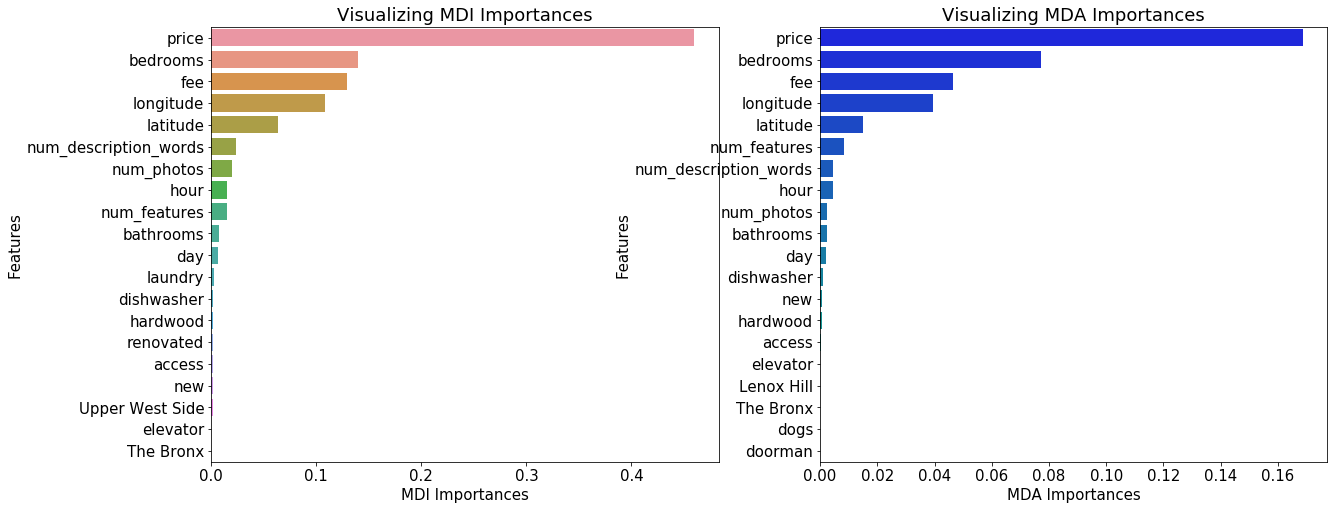

In [38]:
#plotting importances
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x=feature_mdi_top20, y=feature_mdi_top20.index)
plt.xlabel('MDI Importances', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title("Visualizing MDI Importances", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1,2,2)
sns.barplot(x=feature_mda_top20, y=feature_mda_top20.index, palette='winter')
plt.xlabel('MDA Importances', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title("Visualizing MDA Importances", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

**Decision Tree Pruning**

We are going to use RandomizedSearchCV method for our Decision Tree pruning method.

In [39]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [1,3,5,8,10,20,25,50,65, 75,100],
              "max_features": randint(1, 100),
              "min_samples_leaf": randint(1,100),
             }

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5, scoring='roc_auc_ovo')

# Fit it to the data
tree_cv.fit(x_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'max_depth': 100, 'max_features': 41, 'min_samples_leaf': 84}


In [40]:
tree_cv.best_score_

0.7313392446654899

Now we will tune the model with the suggested best hyperparameter set.

In [41]:
DC2 = DecisionTreeClassifier(max_depth=10, max_features=43, min_samples_leaf=73, random_state = 42).fit(x_train,y_train)
y_pred4 = DC2.predict(x_test)
y_pred4_proba = DC2.predict_proba(x_test)

In [42]:
#checking model performance
log_loss4 = log_loss(y_test, y_pred4_proba)
print("Log loss score: ", log_loss4)
acc4 = accuracy_score(y_test, y_pred4)
print("Accuracy score: ",acc4)
rec4 = recall_score(y_test, y_pred4, average='weighted')
print("Recall score: ", rec4)
roc_auc4 = roc_auc_score(y_test, y_pred4_proba, multi_class='ovo')
print("ROC AUC score: ", roc_auc4)

Log loss score:  0.7782539663739126
Accuracy score:  0.6774403118401819
Recall score:  0.6774403118401819
ROC AUC score:  0.7268909979254229


Now we will compile all the scores into one table to compare the performances of the model and choose the best one.

In [50]:
metrics = ['Log loss', 'Accuracy', 'Recall', 'ROC AUC']
model1_scores = [log_loss1, acc1, rec1, roc_auc1]
model2_scores = [log_loss2, acc2, rec2, roc_auc2]
modelDC1_scores = [log_loss3, acc3, rec3, roc_auc3]
modelDC2_scores = [log_loss4, acc4, rec4, roc_auc4]

In [51]:
models_performance = pd.DataFrame({'Metric': metrics, 'Model 1 RF': model1_scores, 'Model 2 RF': model2_scores, 'Model 3 DT': modelDC1_scores, 'Model 4 DT': modelDC2_scores}).set_index('Metric')
models_performance

,Model 1 RF,Model 2 RF,Model 3 DT,Model 4 DT
Metric,,,,
Log loss,0.702061,0.678077,0.724452,0.778254
Accuracy,0.691632,0.690109,0.682270,0.677440
Recall,0.691632,0.690109,0.682270,0.677440
ROC AUC,0.742914,0.752386,0.724384,0.726891


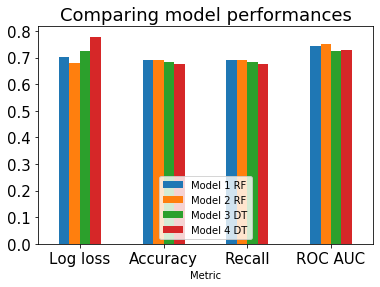

In [52]:
models_performance.plot(kind='bar')
plt.title('Comparing model performances', fontsize=18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)
plt.legend(loc='lower center');

The output of model scores yields interesting patterns. After pruning the random forest model, we're getting slightly better scores (decrease in log loss and increase in roc auc scores). However, for decision trees, that's not quite the case with only a tiny improvement of roc auc score. Interestingly, after pruning the decision tree model, we're getting higher log loss score which might raise the sign of having a worse model. Accuracy scores are more or less the same across all models (around 68-69 %). Recall scores also closely resemble accuracy scores. 
After comparing all these model performances, we conclude that the Model 2 (Random Forest after Pruning) is the best one as evidenced by lower log loss score and higher roc auc score. In this case, we give more weight to the roc auc score as it is an objective indicator of how good the model is at distinguishing classes and incoporates accuracy, sensitivity and specificity scores.